In [1]:
import os
import subprocess
import shutil

import tqdm
from tqdm import tqdm

from datetime import datetime, date, timedelta
from dateutil import relativedelta

import gzip
import requests
import zipfile

import re

import pandas as pd
# import geopandas as gdp
import numpy as np

import altair as alt
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from sklearn.manifold import TSNE

In [2]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Transactional dataset

### Data preparation

In [3]:
# Transactional dataset reading
trans_data = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Transactions/transactions.csv", on_bad_lines="skip", dtype={"app_name": "string", "event_id": "string", "event_time": "string", "event_created_at": "string", "user_id": int, "user_created_at": "string", "appsflyer_id": "string", "source": "string", "product_type": "string", "country": "string", "subscription_duration": "string", "trial_duration": float, "trial": int, "transaction_type": "string", "currency": "string", "usd_gross": float, "usd_gross2": float, "transaction_id": "string", "original_transaction_id": "string", "purchase_date": "string", "original_purchase_date": "string", "object": "string", "platform": "string"})

In [4]:
# Checking transactional dataframe columns types
trans_data.dtypes

app_name                    string
event_id                    string
event_time                  string
event_created_at            string
user_id                      int64
user_created_at             string
appsflyer_id                string
source                      string
product_type                string
product_id                  object
country                     string
subscription_duration       string
trial_duration             float64
trial                        int64
transaction_type            string
currency                    string
usd_gross                  float64
usd_gross_2                float64
transaction_id              string
original_transaction_id     string
purchase_date               string
original_purchase_date      string
expiry_date                 object
platform                    string
dtype: object

In [5]:
# Checking transactional dataframe for duplicates
trans_data[trans_data.duplicated(keep=False)]

,app_name,event_id,event_time,event_created_at,user_id,user_created_at,appsflyer_id,source,product_type,product_id,...,transaction_type,currency,usd_gross,usd_gross_2,transaction_id,original_transaction_id,purchase_date,original_purchase_date,expiry_date,platform


In [6]:
# Calculating number of NaN values in each column in transactional dataframe
trans_data.isna().sum()

app_name                         0
event_id                         0
event_time                       0
event_created_at                 0
user_id                          0
user_created_at                  0
appsflyer_id                 13581
source                           0
product_type                     0
product_id                       0
country                    1317146
subscription_duration       192460
trial_duration              195592
trial                            0
transaction_type                 0
currency                   2084927
usd_gross                        0
usd_gross_2                      0
transaction_id                   0
original_transaction_id      16032
purchase_date                    0
original_purchase_date           0
expiry_date                 195055
platform                     22594
dtype: int64

In [7]:
# Removing rows if value in appsflyer_id column in transactional dataframe is NaN
trans_data = trans_data[~(trans_data["appsflyer_id"].isna())]

In [8]:
# Removing rows if value in original_transaction_id column in transactional dataframe is not in transactional dataframe
ids_to_remove = trans_data[~trans_data["original_transaction_id"].isin(trans_data["transaction_id"])]["appsflyer_id"].unique()
trans_data = trans_data[trans_data["original_transaction_id"].isin(trans_data["transaction_id"])]

### Data visualisation

#### All and first transactions distribution

In [9]:
# Converting type of event_time column in transactional dataframe to datetime
trans_data["event_time"] = pd.to_datetime(trans_data["event_time"], format="%Y-%m-%d %H:%M:%S")
# Creating event_year_month column from event_time column in transactional dataframe
trans_data["event_year_month"] = pd.to_datetime(trans_data["event_time"]).dt.date

In [10]:
# Creating grouped by date dataframe on transactions
date_trans = trans_data[trans_data["transaction_type"] == "income"].groupby(["event_year_month"])["usd_gross"].aggregate(["count"]).reset_index()
# Converting type of event_year_month column to datetime
date_trans["event_year_month"] = date_trans["event_year_month"].astype("datetime64[ns]") 

In [11]:
# Creating line chart visualisation of grouped by date dataframe on transactions count
date_trans_count_abs = alt.Chart(date_trans).mark_line().encode(
    x=alt.X("event_year_month:T", timeUnit="yearmonthdate", axis=alt.Axis(gridColor="lightgray", title="Date", format="%b, %Y")),
    y=alt.Y("count:Q", axis=alt.Axis(gridColor="lightgray", title="Number of transactions")),
    tooltip=[alt.Tooltip("event_year_month:T", timeUnit="yearmonthdate", format="%B %d, %Y", title="Date"), alt.Tooltip("count:Q", title="Number of transactions")]
)

In [12]:
# Creating grouped by date dataframe on first transactions
date_first_trans = trans_data[(trans_data["transaction_type"] == "income") & (trans_data["transaction_id"] == trans_data["original_transaction_id"])].groupby(["event_year_month"])["usd_gross"].aggregate(["count"]).reset_index()
# Converting type of event_year_month column to datetime
date_first_trans["event_year_month"] = date_first_trans["event_year_month"].astype("datetime64[ns]") 

In [13]:
# Creating line chart visualisation of grouped by date dataframe on first transactions count
date_first_trans_count_abs = alt.Chart(date_first_trans).mark_line(opacity=0.5).encode(
    x=alt.X("event_year_month:T", timeUnit="yearmonthdate", axis=alt.Axis(gridColor="lightgray", title="Date", format="%b, %Y")),
    y=alt.Y("count:Q", axis=alt.Axis(gridColor="lightgray", title="Number of transactions")),
    tooltip=[alt.Tooltip("event_year_month:T", timeUnit="yearmonthdate", format="%B %d, %Y", title="Date"), alt.Tooltip("count:Q", title="Number of first transactions")]
)

In [14]:
# Merging two visualisations
(date_trans_count_abs + date_first_trans_count_abs).properties(width=900, height=600, title=alt.TitleParams(text=["Distribution of daily number of transactions"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.LayerChart(...)

#### Transactions by product type distribution

In [15]:
# Creating grouped by date and product_type dataframe on transactions
date_prd_type_trans = trans_data[trans_data["transaction_type"] == "income"].groupby(["event_year_month", "product_type"])["usd_gross"].aggregate(["count", "sum"]).reset_index()
# Converting column event_year_month type to datetime
date_prd_type_trans["event_year_month"] = date_prd_type_trans["event_year_month"].astype("datetime64[ns]") 

In [16]:
# Creating line chart visualisation of grouped by date and product_type dataframe on transactions count
date_prd_type_count_rel = alt.Chart(date_prd_type_trans).transform_joinaggregate(
    total="sum(count)",
    groupby=["event_year_month"]  
).transform_calculate(
    fraction="datum.count/datum.total"
).mark_line().encode(
    x=alt.X("event_year_month:T", timeUnit="yearmonthdate", axis=alt.Axis(gridColor="lightgray", title="Date", format="%b, %Y")),
    y=alt.Y("fraction:Q", axis=alt.Axis(format="%", gridColor="lightgray", title="Percent of transactions")),
    color=alt.Color("product_type:N", title="Product type"),
    tooltip=[alt.Tooltip("event_year_month:T", timeUnit="yearmonthdate", format="%B %d, %Y", title="Date"), alt.Tooltip("fraction:Q", format=".0%", title="Percent of transactions")]
)

In [17]:
# Creating line chart visualisation of grouped by date and product_type dataframe on transactions sum
date_prd_type_sum_rel = alt.Chart(date_prd_type_trans).transform_joinaggregate(
    total="sum(sum)",
    groupby=["event_year_month"]  
).transform_calculate(
    fraction="datum.sum/datum.total"
).mark_line(opacity=0.5).encode(
    x=alt.X("event_year_month:T", timeUnit="yearmonthdate", axis=alt.Axis(gridColor="lightgray", title="Date", format="%b, %Y")),
    y=alt.Y("fraction:Q", axis=alt.Axis(format="%", gridColor="lightgray", title="Percent of transactions")),
    color=alt.Color("product_type:N", title="Product type"),
    tooltip=[alt.Tooltip("event_year_month:T", timeUnit="yearmonthdate", format="%B %d, %Y", title="Date"), alt.Tooltip("fraction:Q", format=".0%", title="Percent of transactions revenue")]
)

In [18]:
# Merging two visualisations
(date_prd_type_count_rel + date_prd_type_sum_rel).properties(width=900, height=600, title=alt.TitleParams(text=["Distribution of daily number of transactions in terms of product type"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.LayerChart(...)

#### Subscription transactions by subscription duration and platform distribution

In [19]:
# Renaming subscription_duration values in transactions dataframe
trans_data["subscription_duration"] = trans_data["subscription_duration"].replace({"180": "6 months", "1m": "1 month", "1w": "1 week", 
                                                                                   "1y": "1 year", "2w": "2 weeks", "30": "1 month",
                                                                                   "3m": "3 months", "6m": "6 months", "90": "3 months"})

In [20]:
# Creating grouped by subscription_duration and platform dataframe on transactions
sub_dur_platform_trans = trans_data[(trans_data["transaction_type"] == "income") & (trans_data["product_type"] == "subscription")].groupby(["subscription_duration", "platform"])["usd_gross"].aggregate(["count", "sum"]).reset_index()

In [21]:
# Creating grouped bar chart visualisation of grouped by subscription_duration and platform dataframe on transactions count
sub_dur_platform_count_rel = alt.Chart(sub_dur_platform_trans).transform_joinaggregate(
    total="sum(count)", groupby=["platform"]
).transform_calculate(
    fraction="datum.count/datum.total"
).mark_bar().encode(
    x=alt.X("fraction:Q", scale=alt.Scale(domain=[0, 1]), axis=alt.Axis(format="%", title="Percent of transactions")),
    y=alt.Y("platform:N", axis=alt.Axis(title=None, labels=False, ticks=False)),
    color=alt.Color("platform:N", legend=alt.Legend(title="Platform")),
    row=alt.Row("subscription_duration:N", title="Subscription duration", sort=["1 week", "3 months", "1 month", "lifetime", "1 year", "6 months", "2 weeks"]),
    tooltip=[alt.Tooltip("subscription_duration:N", title="Subscription duration"), alt.Tooltip("platform:N", title="Platform"), alt.Tooltip("fraction:Q", format=".0%", title="Percent of transactions")]
).properties(width=450, height=65)

In [22]:
# Creating grouped bar chart visualisation of grouped by subscription_duration and platform dataframe on transactions sum
sub_dur_platform_sum_rel = alt.Chart(sub_dur_platform_trans).transform_joinaggregate(
    total="sum(sum)", groupby=["platform"]
).transform_calculate(
    fraction="datum.sum/datum.total"
).mark_bar().encode(
    x=alt.X("fraction:Q", scale=alt.Scale(domain=[0, 1]), axis=alt.Axis(format="%", title="Percent of transactions revenue")),
    y=alt.Y("platform:N", axis=alt.Axis(title=None, labels=False, ticks=False)),
    color=alt.Color("platform:N", legend=alt.Legend(title="Platform")),
    row=alt.Row("subscription_duration:N", title=None, sort=["1 week", "3 months", "1 month", "lifetime", "1 year", "6 months", "2 weeks"]),
    tooltip=[alt.Tooltip("subscription_duration:N", title="Subscription duration"), alt.Tooltip("platform:N", title="Platform"), alt.Tooltip("fraction:Q", format=".0%", title="Percent of transactions revenue")]
).properties(width=450, height=65)

In [23]:
# Concatinating two visualisations
alt.hconcat(
    sub_dur_platform_count_rel, 
    sub_dur_platform_sum_rel
).properties(title=alt.TitleParams(text=["Distribution of subscription-based transactions in terms of device and renewal period"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.HConcatChart(...)

#### In-app transactions by product ID and platform distribution

In [24]:
# Creating iap_product_id column from product_id column in transactional dataframe
trans_data["iap_product_id"] = (trans_data["product_id"].str.startswith("chat"))
trans_data["iap_product_id"] = trans_data["iap_product_id"].replace({True: "Chat", False: "Other"})

In [25]:
# Creating grouped by iap_product_id and platform dataframe on transactions
iap_id_platform_trans = trans_data[(trans_data["transaction_type"] == "income") & (trans_data["product_type"] == "iap")].groupby(["iap_product_id", "platform"])["usd_gross"].aggregate(["count", "sum"]).reset_index()

In [26]:
# Creating grouped bar chart visualisation of grouped by iap_product_id and platform dataframe on transactions count
iap_id_platform_count_rel = alt.Chart(iap_id_platform_trans).transform_joinaggregate(
    total="sum(count)", groupby=["platform"]
).transform_calculate(
    fraction="datum.count/datum.total"
).mark_bar().encode(
    x=alt.X("fraction:Q", scale=alt.Scale(domain=[0, 1]), axis=alt.Axis(format="%", title="Percent of transactions")),
    y=alt.Y("platform:N", axis=alt.Axis(title=None, labels=False, ticks=False)),
    color=alt.Color("platform:N", legend=alt.Legend(title="Platform")),
    row=alt.Row("iap_product_id:N", title="In-app product type"),
    tooltip=[alt.Tooltip("iap_product_id:N", title="In-app product type"), alt.Tooltip("platform:N", title="Platform"), alt.Tooltip("fraction:Q", format=".0%", title="Percent of transactions")]
).properties(width=450, height=65)

In [27]:
# Creating grouped bar chart visualisation of grouped by iap_product_id and platform dataframe on transactions sum
iap_id_platform_sum_rel = alt.Chart(iap_id_platform_trans).transform_joinaggregate(
    total="sum(sum)", groupby=["platform"]
).transform_calculate(
    fraction="datum.sum/datum.total"
).mark_bar().encode(
    x=alt.X("fraction:Q", scale=alt.Scale(domain=[0, 1]), axis=alt.Axis(format="%", title="Percent of transactions revenue")),
    y=alt.Y("platform:N", axis=alt.Axis(title=None, labels=False, ticks=False)),
    color=alt.Color("platform:N", legend=alt.Legend(title="Platform")),
    row=alt.Row("iap_product_id:N", title=None),
    tooltip=[alt.Tooltip("iap_product_id:N", title="In-app product type"), alt.Tooltip("platform:N", title="Platform"), alt.Tooltip("fraction:Q", format=".0%", title="Percent of transactions revenue")]
).properties(width=450, height=65)

In [28]:
# Concatinating two visualisations
alt.hconcat(
    iap_id_platform_count_rel, 
    iap_id_platform_sum_rel
).properties(title=alt.TitleParams(text=["Distribution of in-app-based transactions in terms of device and service type"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.HConcatChart(...)

### Feature engineering

In [29]:
# Function for dataframe to dictionary convertion
def trans_history_for_users(data):
    users_trans_history = {}
    for i in data:
        try:
            users_trans_history[i["appsflyer_id"]].append(i)
        except KeyError:
            users_trans_history[i["appsflyer_id"]] = []
            users_trans_history[i["appsflyer_id"]].append(i)
    return users_trans_history

In [30]:
# Converting transactions dataframe to dictionary
users_orders_dict = trans_history_for_users(trans_data.to_dict("records"))

In [31]:
# Function for key transactional metrics in terms of users calculation
def metrics_for_users(users_orders_history):
    
    users_metrics = {}
    product_types = {"subscription": "sub", "inapp_chat": "iap_chat", "inapp_other": "iap_other"}    
    
    for user_id in users_orders_history.keys():
        
        orders_history = users_orders_history[user_id] 
        
        # Creating dictionary to store calculation results              
        user_metrics = {} 
        
        user_metrics["first_trans_date"], user_metrics["last_trans_date"], user_metrics["lifetime_mth"] = orders_history[0]["purchase_date"], orders_history[0]["purchase_date"], 0       
        
        for product_type in product_types.keys():
            
            user_metrics["paying_" + product_types[product_type]], user_metrics["num_in_" + product_types[product_type]] = False, 0
            user_metrics["gross_rev_" + product_types[product_type]], user_metrics["gross_rev_" + product_types[product_type] + "_per_mth"] = 0, 0
            user_metrics["net_rev_" + product_types[product_type]], user_metrics["net_rev_" + product_types[product_type] + "_per_mth"] = 0, 0
            user_metrics["refunding_" + product_types[product_type]], user_metrics["num_out_" + product_types[product_type]] = False, 0
            user_metrics["refund_sum_" + product_types[product_type]], user_metrics["refund_rate_" + product_types[product_type]] = 0, 0
        
        for order in orders_history:
            
            # First and last transaction date calculation
            if order["purchase_date"] <= user_metrics["first_trans_date"]:
                user_metrics["first_trans_date"] = order["purchase_date"]
            if order["purchase_date"] >= user_metrics["last_trans_date"]:
                user_metrics["last_trans_date"] = order["purchase_date"]
            
            # Defining product type of transaction
            if order["product_type"] == "subscription":
                product_type = product_types["subscription"]
            elif order["product_type"] == "iap" and order["product_id"].startswith("chat"):
                product_type = product_types["inapp_chat"]
            else:
                product_type = product_types["inapp_other"]
            
            # Number of income transactions and gross revenue calculation
            if order["transaction_type"] == "income":
                user_metrics["paying_" + product_type] = True
                user_metrics["num_in_" + product_type] += 1
                user_metrics["gross_rev_" + product_type] += order["usd_gross"]
            else:
            # Number of outcome transactions and refunded amount calculation
                user_metrics["refunding_" + product_type] = True
                user_metrics["num_out_" + product_type] += 1
                # Changing value of outcome transaction by value of the same income transaction
                refund = None
                for order_ in orders_history:
                    if (order_["transaction_type"] == "income" and (order_["purchase_date"] == order["purchase_date"] or order_["transaction_id"] == order["transaction_id"])):
                        refund = order_["usd_gross"]
                        break
                user_metrics["refund_sum_" + product_type] += refund if refund is not None else order["usd_gross"]
        
        # User lifetime in moths calculation
        user_metrics["lifetime_mth"] = relativedelta.relativedelta(datetime.strptime(user_metrics["last_trans_date"], "%Y-%m-%d %H:%M:%S.%f"), datetime.strptime(user_metrics["first_trans_date"], "%Y-%m-%d %H:%M:%S.%f")).months + 1 
        
        for product_type in product_types.keys(): 
        
            # Gross revenue per month calculation
            user_metrics["gross_rev_" + product_types[product_type] + "_per_mth"] = user_metrics["gross_rev_" + product_types[product_type]] / user_metrics["lifetime_mth"]
            # Net revenue and net revenue per month calculation
            user_metrics["net_rev_" + product_types[product_type]] = user_metrics["gross_rev_" + product_types[product_type]] - user_metrics["refund_sum_" + product_types[product_type]]
            user_metrics["net_rev_" + product_types[product_type] + "_per_mth"] = user_metrics["net_rev_" + product_types[product_type]] / user_metrics["lifetime_mth"]
            # Refund rate calculation
            try:
                user_metrics["refund_rate_" + product_types[product_type]] = user_metrics["refund_sum_" + product_types[product_type]] / user_metrics["gross_rev_" + product_types[product_type]] 
            except ZeroDivisionError:
                user_metrics["refund_rate_" + product_types[product_type]] = 0
        
        users_metrics[user_id] = user_metrics
    
    return users_metrics

In [32]:
# Calculating key transactional metrics in terms of users and returning key transactional metrics dictionary
users_trans_dict = metrics_for_users(users_orders_dict)
# Converting key transactional metrics dictionary to key transactional metrics dataframe
users_trans_data = pd.DataFrame.from_dict(users_trans_dict).T
# Converting index column in key transactional metrics dataframe to ordinary column named appsflyer_id
users_trans_data = users_trans_data.reset_index().rename(columns={"index": "appsflyer_id"})

In [33]:
# Removing rows with number of outcome transactions greater than number of income in key transactional metrics dataframe
users_trans_data = users_trans_data[users_trans_data["num_in_sub"] >= users_trans_data["num_out_sub"]]
users_trans_data = users_trans_data[users_trans_data["num_in_iap_chat"] >= users_trans_data["num_out_iap_chat"]]
users_trans_data = users_trans_data[users_trans_data["num_in_iap_other"] >= users_trans_data["num_out_iap_other"]]

# Removing rows with negative net revenue in key transactional metrics dataframe
users_trans_data = users_trans_data[users_trans_data["net_rev_sub"] >= 0]
users_trans_data = users_trans_data[users_trans_data["net_rev_iap_chat"] >= 0]
users_trans_data = users_trans_data[users_trans_data["net_rev_iap_other"] >= 0]

In [34]:
# Converting column types in key transactional metrics dataframe
users_trans_data = users_trans_data.astype({"lifetime_mth": int, 
                                            "paying_sub": int, "num_in_sub": int, "gross_rev_sub": float, "gross_rev_sub_per_mth": float, "net_rev_sub": float, "net_rev_sub_per_mth": float,
                                            "refunding_sub": int, "num_out_sub": int, "refund_sum_sub": float, "refund_rate_sub": float,
                                            "paying_iap_chat": int, "num_in_iap_chat": int, "gross_rev_iap_chat": float, "gross_rev_iap_chat_per_mth": float, "net_rev_iap_chat": float, "net_rev_iap_chat_per_mth": float,
                                            "refunding_iap_chat": int, "num_out_iap_chat": int, "refund_sum_iap_chat": float, "refund_rate_iap_chat": float,
                                            "paying_iap_other": int, "num_in_iap_other": int, "gross_rev_iap_other": float, "gross_rev_iap_other_per_mth": float, "net_rev_iap_other": float, "net_rev_iap_other_per_mth": float,
                                            "refunding_iap_other": int, "num_out_iap_other": int, "refund_sum_iap_other": float, "refund_rate_iap_other": float})

## Users dataset

### Data preparation

In [35]:
# Users datasets reading
users_data1 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Users/users_jan_mar_2021.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_time": "string", "event_id": "string", "event_created_at": "string", "user_id": int, "appsflyer_id": "string", "user_created_at": "string", "zodiac_id": int, "birth_day": "string", "birth_time": "string", "birth_place": "string", "name": "string", "gender": "string", "relationship": "string"})
users_data2 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Users/users_apr_jun_2021.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_time": "string", "event_id": "string", "event_created_at": "string", "user_id": int, "appsflyer_id": "string", "user_created_at": "string", "zodiac_id": int, "birth_day": "string", "birth_time": "string", "birth_place": "string", "name": "string", "gender": "string", "relationship": "string"})
users_data3 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Users/users_aug_oct_2021.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_time": "string", "event_id": "string", "event_created_at": "string", "user_id": int, "appsflyer_id": "string", "user_created_at": "string", "zodiac_id": int, "birth_day": "string", "birth_time": "string", "birth_place": "string", "name": "string", "gender": "string", "relationship": "string"})
users_data4 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Users/users_nov_dec_2021.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_time": "string", "event_id": "string", "event_created_at": "string", "user_id": int, "appsflyer_id": "string", "user_created_at": "string", "zodiac_id": int, "birth_day": "string", "birth_time": "string", "birth_place": "string", "name": "string", "gender": "string", "relationship": "string"})
users_data5 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Users/users_jan_may_2022.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_time": "string", "event_id": "string", "event_created_at": "string", "user_id": int, "appsflyer_id": "string", "user_created_at": "string", "zodiac_id": int, "birth_day": "string", "birth_time": "string", "birth_place": "string", "name": "string", "gender": "string", "relationship": "string"})
users_data6 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Users/users_jun_oct_2022.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_time": "string", "event_id": "string", "event_created_at": "string", "user_id": int, "appsflyer_id": "string", "user_created_at": "string", "zodiac_id": int, "birth_day": "string", "birth_time": "string", "birth_place": "string", "name": "string", "gender": "string", "relationship": "string"})
users_data7 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Users/users_nov_dec_2022.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_time": "string", "event_id": "string", "event_created_at": "string", "user_id": int, "appsflyer_id": "string", "user_created_at": "string", "zodiac_id": int, "birth_day": "string", "birth_time": "string", "birth_place": "string", "name": "string", "gender": "string", "relationship": "string"})

In [36]:
# Users dataframes merging
users_data = pd.concat([users_data1, users_data2, users_data3, users_data4, users_data5, users_data6, users_data7], axis=0)

In [37]:
# Checking users dataframe columns types
users_data.dtypes

app_name            string
platform            string
event_time          string
event_id            string
event_created_at    string
user_id              int64
appsflyer_id        string
user_created_at     string
zodiac_id            int64
birth_day           string
birth_time          string
birth_place         string
name                string
gender              string
relationship        string
dtype: object

In [38]:
# Checking users dataframe for duplicates
users_data[users_data.duplicated(keep=False)]

,app_name,platform,event_time,event_id,event_created_at,user_id,appsflyer_id,user_created_at,zodiac_id,birth_day,birth_time,birth_place,name,gender,relationship


In [39]:
# Calculating number of NaN values in each column in users dataframe
users_data.isna().sum()

app_name                  0
platform              11824
event_time                0
event_id                  0
event_created_at          0
user_id                   0
appsflyer_id        1577053
user_created_at           0
zodiac_id                 0
birth_day                 0
birth_time          2868936
birth_place          524175
name                1718251
gender                44419
relationship        3271454
dtype: int64

In [40]:
# Removing rows with impossible birthday values in birth_day column in users dataframe
users_data = users_data[users_data["birth_day"] >= "1923-01-01 00:00:00"]
users_data = users_data[users_data['birth_day'] <= "2022-12-31 23:59:59"]

In [41]:
# Converting type of birth_day column in users dataframe to datetime
users_data["birth_day"] = pd.to_datetime(users_data["birth_day"], format="%Y-%m-%d %H:%M:%S")

### Feature engineering

In [42]:
# Funcion for age calculation
def age(birthday):
    today = date.today()
    return today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day))

In [43]:
# Calculating age in age column in users dataframe
users_data["age"] = users_data["birth_day"].apply(age)

### Data visualisation

#### Age and gender distibution

In [44]:
# Creating base dataframe for age distrbution calculation
age_base = pd.DataFrame({"age": list(range(1, 101, 1))})

# Creating grouped by age dataframe on female users
female_age = users_data[users_data["gender"] == "female"].groupby("age")["age"].count().reset_index(name="counter")
female = age_base.merge(female_age, on="age", how="left").fillna(0)

# Creating grouped by age dataframe on male users
male_age = users_data[users_data["gender"] == "male"].groupby("age")["age"].count().reset_index(name="counter")
male = age_base.merge(male_age, on="age", how="left").fillna(0)

In [45]:
# Creating bar chart visualisation of grouped by age dataframe on female users
bar_chart_female = alt.Chart(female).mark_bar(size=3, color="#EEB6BB").encode(
    x=alt.X("counter:Q", scale=alt.Scale(domain=(0, 500000)), sort=alt.SortOrder("descending"), axis=alt.Axis(gridColor="lightgray", title="Number of users")),
    y=alt.Y("age:N", sort=alt.SortOrder("descending"), axis=None),
    tooltip=[alt.Tooltip("age:N", title="Age"), alt.Tooltip("counter:Q", title="Number of users")]
).properties(title=alt.TitleParams(text=["Female"], color="gray", fontWeight="normal", fontStyle="normal", baseline="bottom"))

In [46]:
# Creating bar chart visualisation of grouped by age dataframe on male users
bar_chart_male = alt.Chart(male).mark_bar(size=3).encode(
    x=alt.X("counter:Q", scale=alt.Scale(domain=(0, 500000)), axis=alt.Axis(gridColor="lightgray", title="Number of users")),
    y=alt.Y("age:N", sort=alt.SortOrder("descending"), axis=None),
    tooltip=[alt.Tooltip("age:N", title="Age"), alt.Tooltip("counter:Q", title="Number of users")]
).properties(title=alt.TitleParams(text=["Male"], color="gray", fontWeight="normal", fontStyle="normal", baseline="bottom"))

In [47]:
# Creating text visualisation of grouped by age pd.DataFrame(np.arange(0, 100, 5), columns = ["age"]) on users
text_age = alt.Chart(pd.DataFrame(np.arange(0, 100, 5), columns = ["age"])).mark_text(size=7).encode(
    y=alt.Y("age", axis=None),
    text=alt.Text("age"),
    color=alt.condition(alt.datum.age > 0, alt.value("#000000"), alt.value("#FFFFFF")),
)

In [48]:
# Concatinating two visualisations
alt.hconcat(
    bar_chart_female.properties(width=450, height=600), 
    text_age.properties(width=10, height=600), 
    bar_chart_male.properties(width=450, height=600), spacing=5
).properties(title=alt.TitleParams(text=["Distribution of users by gender and age"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.HConcatChart(...)

## Installs dataset

### Data preparation

In [49]:
# Installs datasets reading
installs_data1 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Installs/installs_jan_feb_2021.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_id": "string", "event_time": "string", "event_created_at": "string", "install_time": "string", "media_source": "string", "campaign": "string", "campaign_id": "string", "adset": "string", "adset_id": "string", "ad": "string", "ad_id": "string", "region": "string", "country_code": "string", "state": "string", "city": "string", "language": "string", "appsflyer_id": "string", "device_type": "string", "os_version": "string", "app_version": "string"})
installs_data2 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Installs/installs_mar_may_2021.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_id": "string", "event_time": "string", "event_created_at": "string", "install_time": "string", "media_source": "string", "campaign": "string", "campaign_id": "string", "adset": "string", "adset_id": "string", "ad": "string", "ad_id": "string", "region": "string", "country_code": "string", "state": "string", "city": "string", "language": "string", "appsflyer_id": "string", "device_type": "string", "os_version": "string", "app_version": "string"})
installs_data3 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Installs/installs_jun_aug_2021.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_id": "string", "event_time": "string", "event_created_at": "string", "install_time": "string", "media_source": "string", "campaign": "string", "campaign_id": "string", "adset": "string", "adset_id": "string", "ad": "string", "ad_id": "string", "region": "string", "country_code": "string", "state": "string", "city": "string", "language": "string", "appsflyer_id": "string", "device_type": "string", "os_version": "string", "app_version": "string"})
installs_data4 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Installs/installs_sep_dec_2021.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_id": "string", "event_time": "string", "event_created_at": "string", "install_time": "string", "media_source": "string", "campaign": "string", "campaign_id": "string", "adset": "string", "adset_id": "string", "ad": "string", "ad_id": "string", "region": "string", "country_code": "string", "state": "string", "city": "string", "language": "string", "appsflyer_id": "string", "device_type": "string", "os_version": "string", "app_version": "string"})
installs_data5 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Installs/installs_jan_jun_2022.csv", on_bad_lines="skip", dtype={"app_name": "string", "platform": "string", "event_id": "string", "event_time": "string", "event_created_at": "string", "install_time": "string", "media_source": "string", "campaign": "string", "campaign_id": "string", "adset": "string", "adset_id": "string", "ad": "string", "ad_id": "string", "region": "string", "country_code": "string", "state": "string", "city": "string", "language": "string", "appsflyer_id": "string", "device_type": "string", "os_version": "string", "app_version": "string"})
installs_data6 = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Installs/installs_jul_dec_2022.csv", on_bad_lines="skip", names=["app_name", "platform", "event_id", "event_time", "event_created_at", "install_time", "media_source", "campaign", "campaign_id", "adset", "adset_id", "ad", "ad_id", "region", "country_code", "state", "city","language", "appsflyer_id", "device_type", "os_version", "app_version"], dtype={"app_name": "string", "platform": "string", "event_id": "string", "event_time": "string", "event_created_at": "string", "install_time": "string", "media_source": "string", "campaign": "string", "campaign_id": "string", "adset": "string", "adset_id": "string", "ad": "string", "ad_id": "string", "region": "string", "country_code": "string", "state": "string", "city": "string", "language": "string", "appsflyer_id": "string", "device_type": "string", "os_version": "string", "app_version": "string"})

In [50]:
# Installs dataframes merging
installs_data = pd.concat([installs_data1, installs_data2, installs_data3, installs_data4, installs_data5, installs_data6], axis=0)

In [51]:
# Checking installs dataframe columns types
installs_data.dtypes

app_name            string
platform            string
event_id            string
event_time          string
event_created_at    string
install_time        string
media_source        string
campaign            string
campaign_id         string
adset               string
adset_id            string
ad                  string
ad_id               string
region              string
country_code        string
state               string
city                string
language            string
appsflyer_id        string
device_type         string
os_version          string
app_version         string
dtype: object

In [52]:
# Checking installs dataframe for duplicates
installs_data[installs_data.duplicated(keep=False)]

,app_name,platform,event_id,event_time,event_created_at,install_time,media_source,campaign,campaign_id,adset,...,ad_id,region,country_code,state,city,language,appsflyer_id,device_type,os_version,app_version
13322,nebula,ios,0046d265-ff34-5934-97ea-0316327cb425,2022-02-08 22:47:00.970000,2022-02-08 22:48:29.910000,2022-02-08 22:47:00.970,Social_facebook,New Landing CAPI,<NA>,<NA>,...,<NA>,AS,QA,DA,Lejbailat,en-QA,1644360359886-6735758,<NA>,15.2.1,4.20.0
13323,nebula,ios,0046d265-ff34-5934-97ea-0316327cb425,2022-02-08 22:47:00.970000,2022-02-08 22:48:29.910000,2022-02-08 22:47:00.970,Social_facebook,New Landing CAPI,<NA>,<NA>,...,<NA>,AS,QA,DA,Lejbailat,en-QA,1644360359886-6735758,<NA>,15.2.1,4.20.0
15115,nebula,ios,a272d97d-6b2a-52fc-870f-d8134903da5b,2022-02-08 22:45:46.506000,2022-02-08 22:46:18.177000,2022-02-08 22:45:46.506,Social_facebook,New Landing CAPI,<NA>,<NA>,...,<NA>,AS,QA,RA,Ar-Rayyan,en-QA,1644360324220-3795077,<NA>,15.1.1,4.20.0
15116,nebula,ios,a272d97d-6b2a-52fc-870f-d8134903da5b,2022-02-08 22:45:46.506000,2022-02-08 22:46:18.177000,2022-02-08 22:45:46.506,Social_facebook,New Landing CAPI,<NA>,<NA>,...,<NA>,AS,QA,RA,Ar-Rayyan,en-QA,1644360324220-3795077,<NA>,15.1.1,4.20.0
67229,nebula,ios,52348e7b-0e87-51c5-b265-2de95994675b,2022-02-08 22:48:22.320000,2022-02-08 22:49:40.622000,2022-02-08 22:48:22.320,organic,<NA>,<NA>,<NA>,...,<NA>,EU,DE,BY,Munich,de-DE,1627389799124-5751534,<NA>,15.3,4.9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551301,nebula,ios,a080ea0c-a50a-53a2-b0ce-502ab40e4c2c,2022-02-08 22:43:58.966000,2022-02-08 22:45:06.351000,2022-02-08 22:43:58.966,organic,<NA>,<NA>,<NA>,...,<NA>,EU,UK,BNH,Brighton,en-GB,1644360148678-7635740,<NA>,15.2.1,4.20.0
2559606,nebula,ios,4f7a71bc-3003-53b5-9401-685c44987c94,2022-02-08 22:43:31.706000,2022-02-08 22:44:12.298000,2022-02-08 22:43:31.706,Social_facebook,New Landing CAPI,<NA>,<NA>,...,<NA>,EU,AT,6,Mixnitz,de-AT,1644360179259-2981233,<NA>,15.3,4.20.0
2559607,nebula,ios,4f7a71bc-3003-53b5-9401-685c44987c94,2022-02-08 22:43:31.706000,2022-02-08 22:44:12.298000,2022-02-08 22:43:31.706,Social_facebook,New Landing CAPI,<NA>,<NA>,...,<NA>,EU,AT,6,Mixnitz,de-AT,1644360179259-2981233,<NA>,15.3,4.20.0
2585721,nebula,android,a213730d-1e71-5e74-9dae-649c52e75a40,2022-02-08 22:40:58.155000,2022-02-08 22:42:21.030000,2022-02-08 22:40:58.155,Facebook Ads,02-08-2022 new ads test CBO High Conv,<NA>,<NA>,...,<NA>,<NA>,US,IL,Danville,English,1644360050672-2743283790293976938,<NA>,11,4.7.13


In [53]:
# Droping duplicated rows in installs dataframe by keeping entry with the newest event time
installs_data = installs_data.sort_values(["appsflyer_id", "event_time"], ascending=False)
installs_data = installs_data.drop_duplicates(["appsflyer_id"], keep="last")

In [54]:
# Calculating number of NaN values in each column in installs dataframe
installs_data.isna().sum()

app_name                  0
platform                  0
event_id                  0
event_time                0
event_created_at          0
install_time              0
media_source        4676952
campaign            6733748
campaign_id         9290857
adset               9352082
adset_id            9437554
ad                  9932891
ad_id               9919719
region              7874648
country_code           4207
state                  7354
city                    238
language            1235347
appsflyer_id              0
device_type         3533346
os_version                0
app_version               0
dtype: int64

In [55]:
# Removing rows in installs dataframe if value in original_transaction_id column in transactional dataframe is not in transactional dataframe
installs_data = installs_data[~(installs_data["appsflyer_id"].isin(ids_to_remove))]

### Data visualisation

#### Countries distribution

In [ ]:
# Countries coordinates dataset reading
countries = gpd.read_file("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Countries/countries_coordinates.json")

In [ ]:
# Creating grouped by country data rame on installs
installs_data_country = installs_data.groupby("country_code")["country_code"].count().reset_index(name="counter")
installs_data_country["country_code"] = installs_data_country["country_code"].replace({"UK": "GB"})

In [ ]:
# Creating background map visulisation of grouped by country dataframe on installs
background_map = alt.Chart(countries).mark_geoshape(fill="lightgray", stroke="white", strokeWidth=1).encode(tooltip=[alt.Tooltip("name:N", title="Country")])

In [ ]:
# Creating color map visulisation of grouped by country dataframe on installs
color_map = alt.Chart(installs_data_country).encode(
    color=alt.Color("counter:Q", scale=alt.Scale(scheme="redyellowblue", reverse=True, domainMid=installs_data_country["counter"].mean()), legend=alt.Legend(tickCount=3, title="Number of installs")),
    detail=alt.Detail("country_code:N"),
    tooltip=[alt.Tooltip("country_code:N", title="Country"), alt.Tooltip("counter:Q", title="Number of installs")]
).transform_lookup(
    lookup="country_code",
    from_=alt.LookupData(data=countries, key="Alpha-2", fields=["type", "properties", "geometry"])
).mark_geoshape()

In [ ]:
# Concatinating two visualisations
(background_map + color_map).properties(width=900, height=600, title=alt.TitleParams(text=["Geographical distribution of installs"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

## Amplitude dataset

### Data preparation

In [ ]:
# Defining configurations for iOS amplitude data downloading

api_key = ...
secret_key = ...
project_id = ...

events = ["zodiac_today_screen_open", "chat_astrologers_screen_open", "chat_screen_open", "chat_astrologer_chat_tap",
          "chat_astrologer_profile_chat_tap", "chat_chatlist_chat_open", "live_chat_terminate_success", 
          "compatibility_screen_open", "compatibility_sphere_screen_open", "compatibility_result_screen_open",
          "nebutalk3_post_success", "nebutalk3_feed_screen_open", "nebulatalk_direct_message", 
          "friends_add_continue_tap"]

path_for_folder = "/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Amplitude/ios"

In [ ]:
# Defining configurations for Android amplitude data downloading

api_key = ...
secret_key = ...
project_id = ...

events = ["zodiac_today_screen_open", "zodiac_screen_open", "chat_astrologers_screen_open", "chat_screen_open", 
          "chat_astrologer_chat_tap", "chat_astrologer_profile_chat_tap", "chat_chatlist_chat_open", 
          "live_chat_terminate_success", "compatibility_screen_open", "compatibility_get_result_tap", 
          "compatibility_result_screen_open", "nebutalk3_post_success", "nebutalk3_feed_screen_open", 
          "nebulatalk_direct_message", "friends_add_continue_tap"]

path_for_folder = "/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Amplitude/android"

In [ ]:
# Function for collecting data from Amplitude API
def collect(startdate, enddate, starttime, endtime):
    
    # Creating data frame for storing results
    result = pd.DataFrame()
    
    # Sending request to Amplitude API
    filename = "from" + startdate + starttime + "to" + enddate + endtime
    try:
        response = requests.get("https://amplitude.com/api/2/export?start=" + startdate + starttime + "&end=" + enddate + endtime, auth=(api_key, secret_key))
    except requests.exceptions.ConnectionError as e:
        return filename
    
    # Downloading archieve to local storage 
    with open(path_for_folder + "/" + "archieves" + "/" + filename + ".zip", "wb") as zipf:
        zipf.write(response.content)
    
    # Unzipping archive in local storage
    try:
        zipfiles = zipfile.ZipFile(path_for_folder + "/" + "archieves" + "/" + filename + ".zip", "r")
    except zipfile.BadZipFile as e:
        return filename

    zipfiles.extractall(path = path_for_folder + "/" + "unarchieves" + "/" + filename) 
    
    # Reading files and writing to data frame for storing results
    directory = path_for_folder + "/" + "unarchieves" + "/" + filename + "/" + project_id
    files = os.listdir(directory)
    for file in tqdm(files):
        with gzip.open(directory + "/" + file) as f:
            temp_result = pd.read_json(f, lines = "True")
            temp_result = temp_result[temp_result["event_type"].isin(events)]
        result = pd.concat([result, temp_result])
    
    os.remove(path_for_folder + "/" + "archieves" + "/" + filename + ".zip")
    shutil.rmtree(path_for_folder + "/" + "unarchieves" + "/" + filename)
    
    return result

In [ ]:
# Collecting data from Amplitude API
start = date(2022, 12, 1)
end = date(2022, 12, 31)
delta = timedelta(days=1)
times = [["T0", "T1"], ["T2", "T3"], ["T4", "T5"], ["T6", "T7"], ["T8", "T9"], ["T10", "T11"], 
         ["T12", "T13"], ["T14", "T15"], ["T16", "T17"], ["T18", "T19"], ["T20", "T21"], ["T22", "T23"]]

errors = list()

while start <= end:
    
    day = start.strftime("%Y%m%d")
    print("Day: " + day)
    
    for time in times:
        print("Time: " + time[0] + " - " + time[1])
        collect_result = collect(day, day, time[0], time[1])
        if isinstance(collect_result, pd.DataFrame):
            collect_result.to_csv(path_for_folder + "/" + "results" + "/" + "from" + day + time[0] + "to" + day + time[1] + ".csv", index=False, compression="gzip")
        else:
            errors.append(collect_result)
            
    print("Results for day " + day + " saved")
    start += delta 

In [ ]:
# Amplitude datasets reading
amplitude_data = pd.DataFrame()
directory = path_for_folder + "results/"
files = os.listdir(directory)

errors = list()

for file in tqdm(files):
    try:
        temp = pd.read_csv(directory + file, compression="gzip", low_memory=False, usecols=["$insert_id", "event_type", "user_id"])
        amplitude_data = pd.concat([amplitude_data, temp])
    except gzip.BadGzipFile as e:
        errors.append(file)
        continue

In [ ]:
# Checking amplitude dataframe columns types
amplitude_data.dtypes

In [ ]:
# Checking amplitude dataframe for duplicates
amplitude_data[amplitude_data.duplicated(keep=False)]

In [ ]:
# Calculating number of NaN values in each column in amplitude dataframe
amplitude_data.isna().sum()

In [ ]:
# Removing rows if value in user_id column in amplitude dataframe is NaN
amplitude_data = amplitude_data[~(amplitude_data["user_id"].isna())]
# Removing rows if value in user_id column in amplitude dataframe is not numeric
amplitude_data = amplitude_data[pd.to_numeric(test11["user_id"], errors="coerce").notnull()]

In [ ]:
# Creating grouped by user_id column from amplitude dataframe dataframe
pivoted_amplitude = pd.pivot_table(amplitude_data, index=["user_id"], columns=["event_type"], values=["$insert_id"], aggfunc="count", fill_value=0)
pivoted_amplitude = pd.DataFrame(pivoted_amplitude.to_records())
# Renaming columns in grouped by user_id column from amplitude dataframe dataframe
pivoted_amplitude = pivoted_amplitude.rename(columns=lambda x: x if pivoted_amplitude.columns.get_loc(x) == 0 else x[16:][:-2])

In [56]:
amplitude_data_ios = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Amplitude/ios/results/pivot_amplitude_ios.csv", on_bad_lines="skip", compression="gzip", low_memory=False)
amplitude_data_android = pd.read_csv("/Users/khrystynaslyusarchuk/Desktop/ucu/Bachelor thesis/Nebula data/Amplitude/android/results/pivot_amplitude_android.csv", on_bad_lines="skip", compression="gzip", low_memory=False)

## Final dataset

### Data preparation

In [57]:
# Filtering transactional dataframe for transactions made in in 2022
trans_data = trans_data[(trans_data["event_time"] >= "2022-01-01 00:00:00") & (trans_data["event_time"] <= "2022-12-31 23:59:59")]

In [58]:
# Filtering users dataframe for users created in 2022
users_data["event_time"] = pd.to_datetime(users_data["event_time"], format="%Y-%m-%d %H:%M:%S")
users_data = users_data[(users_data["event_time"] >= "2022-01-01 00:00:00") & (users_data["event_time"] <= "2022-12-31 23:59:59")]

In [59]:
# Filtering installs dataframe for installs made in 2022
installs_data["install_time"] = pd.to_datetime(installs_data["install_time"], format="%Y-%m-%d %H:%M:%S")
installs_data = installs_data[(installs_data["install_time"] >= "2022-01-01 00:00:00") & (installs_data["install_time"] <= "2022-12-31 23:59:59")]

In [137]:
# Merging installs dataframe with transactions dataframe
merged_data = installs_data[["appsflyer_id", "platform", "country_code"]].merge(users_trans_data[["appsflyer_id", "paying_sub", "net_rev_sub", "net_rev_sub_per_mth", "paying_iap_chat", "net_rev_iap_chat", "net_rev_iap_chat_per_mth"]], how="left", on="appsflyer_id")
# Merging installs dataframe with users dataframe
merged_data = merged_data.merge(users_data[["appsflyer_id", "user_id", "gender", "age"]], how="left", on="appsflyer_id")
# Merging installs dataframe with amplitude Android d|ataframe
merged_data = merged_data.merge(amplitude_data_android[["user_id", "chat_astrologers_screen_open", "compatibility_screen_open", "live_chat_terminate_success", "nebutalk3_feed_screen_open", "zodiac_screen_open"]], how="left", on="user_id")
# Merging installs dataframe with amplitude iOS dataframe
merged_data = merged_data.merge(amplitude_data_ios[["user_id", "chat_astrologers_screen_open", "compatibility_screen_open", "live_chat_terminate_success", "nebutalk3_feed_screen_open", "zodiac_today_screen_open"]], how="left", on="user_id")

In [138]:
# Droping duplicated rows in merged dataframe
merged_data.drop_duplicates(["appsflyer_id"], keep=False, inplace=True)

In [139]:
# Removing rows if value in country_code column in merged dataframe is NaN
merged_data = merged_data[~(merged_data["country_code"].isna())]
# Removing rows if value in gender column in merged dataframe is NaN
merged_data = merged_data[~(merged_data["gender"].isna())]
# Replacing non_binary values in gender column in merged dataframe with female value
merged_data["gender"] = merged_data["gender"].replace("non-binary", "female")

In [140]:
# Filling NaN values in merged dataframe with 0s
merged_data.fillna(0, inplace=True)

In [141]:
# Creating revenue column from the sum of net_rev_sub and net_rev_iap_chat columns from merged dataframe
merged_data["revenue"] = merged_data["net_rev_sub"] + merged_data["net_rev_iap_chat"]
# Creating num_chat_astro_screen_open column from the sum of chat_astrologers_screen_open_x and chat_astrologers_screen_open_y columns from merged dataframe
merged_data["num_chat_astro_screen_open"] = merged_data["chat_astrologers_screen_open_x"] + merged_data["chat_astrologers_screen_open_y"]
# Creating num_live_chat_terminate_success column from the sum of live_chat_terminate_success_x and live_chat_terminate_success_y columns from merged dataframe
merged_data["num_live_chat_terminate_success"] = merged_data["live_chat_terminate_success_x"] + merged_data["live_chat_terminate_success_y"]
# Creating num_comp_screen_open column from the sum of compatibility_screen_open_x and compatibility_screen_open_y columns from merged dataframe
merged_data["num_comp_screen_open"] = merged_data["compatibility_screen_open_x"] + merged_data["compatibility_screen_open_y"]
# Creating num_zodiac_screen_open column from the sum of zodiac_screen_open and zodiac_today_screen_open columns from merged dataframe
merged_data["num_zodiac_screen_open"] = merged_data["zodiac_screen_open"] + merged_data["zodiac_today_screen_open"]

In [142]:
# Converting gender column in merged dataframe to dummy varibale
merged_data["gender"] = pd.get_dummies(merged_data["gender"])["female"]
# Converting platform column in merged dataframe to dummy varibale
merged_data["platform"] = pd.get_dummies(merged_data["platform"])["ios"]

In [143]:
# Filtering merged dataframe for paying users 
merged_data = merged_data[(merged_data["revenue"] > 0)]

In [144]:
# Defining columns to cluster
cols_to_cluster = ["appsflyer_id", "platform", "gender", "age", "revenue", "num_chat_astro_screen_open", "num_comp_screen_open", "num_zodiac_screen_open"]

In [145]:
# Defining in merged dataframe columns for cluseting
merged_data = merged_data[cols_to_cluster]

In [146]:
# Calculating key descriptive statistics for merged data dataframe
merged_data[["platform", "gender", "age", "revenue", "num_zodiac_screen_open", "num_comp_screen_open", "num_chat_astro_screen_open"]].describe().apply(lambda s: s.apply("{0:.2f}".format))

,platform,gender,age,revenue,num_zodiac_screen_open,num_comp_screen_open,num_chat_astro_screen_open
count,276298.00,276298.00,276298.00,276298.00,276298.00,276298.00,276298.00
mean,0.70,0.76,32.26,21.92,37.64,13.35,9.87
std,0.46,0.43,9.22,69.49,99.92,66.03,29.15
min,0.00,0.00,13.00,0.01,0.00,0.00,0.00
25%,0.00,1.00,25.00,7.99,5.00,1.00,0.00
50%,1.00,1.00,32.00,7.99,12.00,4.00,3.00
75%,1.00,1.00,38.00,23.97,35.00,14.00,10.00
max,1.00,1.00,100.00,19805.79,10212.00,31474.00,4002.00


In [147]:
# Defining columns to normalize
cols_to_scale = ["platform", "gender", "age", "revenue", "num_chat_astro_screen_open", "num_comp_screen_open", "num_zodiac_screen_open"]

In [148]:
# Normalizing numeric columns in merged dataframe
merged_data_scaled = merged_data.copy()
merged_data_scaled[cols_to_scale] = stats.zscore(merged_data_scaled[cols_to_scale])
# Detecting and removing outliers in merged dataframe
merged_data_scaled[cols_to_scale] = merged_data_scaled[cols_to_scale][(merged_data_scaled[cols_to_scale] < 3).all(axis=1)]
merged_data_scaled[cols_to_scale] = merged_data_scaled[cols_to_scale][(merged_data_scaled[cols_to_scale] > -3).all(axis=1)]
merged_data_scaled = merged_data_scaled.dropna()

In [149]:
# Sampling merged dataframe
merged_data_scaled = merged_data_scaled.sample(n=20000, random_state=123)

## Clustering

### Correlation

In [150]:
# Creating and visualizing correlation matrix for features for clustering 
correl_matrix = merged_data_scaled[cols_to_scale].corr().reset_index().melt("index")
correl_matrix.columns = ["x1", "x2", "correlation"]

base_matrix = alt.Chart(correl_matrix).transform_filter(alt.datum.x1 < alt.datum.x2).encode(
    x=alt.X("x1:N", axis=alt.Axis(title=None, labelAngle=270, labelFontSize=7.5)),
    y=alt.Y("x2:N", axis=alt.Axis(title=None, labelFontSize=7.5))
)

rects_matrix = base_matrix.mark_rect().encode(color=alt.Color("correlation:Q", scale=alt.Scale(domain=(0, 0.6), scheme="redyellowblue", reverse=True, type="linear"), legend=alt.Legend(title="Correlation")),)

text_correl = base_matrix.mark_text(size=12).encode(color=alt.condition("datum.correlation > 0.1", alt.value("black"), alt.value("white")), text=alt.Text("correlation:Q", format=",.2f"))

(rects_matrix + text_correl).properties(width=500, height=500, title=alt.TitleParams(text=["Correlation matrix for paying users"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.LayerChart(...)

### K-means

In [151]:
merged_data_scaled_kmeans = merged_data_scaled.copy()

In [152]:
# Calculating inertia and silhoutte scores for each possible number of clusters k under k-means cluseting algorithm
num_of_clusters = range(2, 11)
inertias, silhouette_scores = list(), list()

for k in num_of_clusters:
    
    model = KMeans(n_clusters=k, random_state=123, init="k-means++", n_init=10)
    model.fit(merged_data_scaled_kmeans[cols_to_scale])    
    
    inertias.append(model.inertia_) 
    silhouette_scores.append(silhouette_score(merged_data_scaled_kmeans[cols_to_scale], model.labels_))

scores_data_kmeans = pd.DataFrame({"num_of_clusters": num_of_clusters, "inertia": inertias, "silhouette_scores": silhouette_scores})

In [153]:
# Creating line chart visualisation of inertia under k-means cluseting algorithm
inertia_viz_kmeans = alt.Chart(scores_data_kmeans).mark_line(point=True).encode(
    x=alt.X("num_of_clusters:Q", axis=alt.Axis(gridColor="lightgray", tickMinStep=1, title="Number of clusters")),
    y=alt.Y("inertia:Q", axis=alt.Axis(gridColor="lightgray", title="Inertia")),
    tooltip=[alt.Tooltip("num_of_clusters:Q", title="Number of clusters"), alt.Tooltip("inertia:Q", format=",.0f", title="Inertia")]
)

In [154]:
inertia_viz_kmeans.properties(width=900, height=600, title=alt.TitleParams(text=["Elbow graph for k-means algorithm for paying users"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.Chart(...)

In [155]:
# Creating line chart visualisation of silhouette scores under k-means cluseting algorithm
silhouette_scores_viz_kmeans = alt.Chart(scores_data_kmeans).mark_line(point=True).encode(
    x=alt.X("num_of_clusters:Q", axis=alt.Axis(gridColor="lightgray", tickMinStep=1, title="Number of clusters")),
    y=alt.Y("silhouette_scores:Q", scale=alt.Scale(domain=[0, 0.5]), axis=alt.Axis(gridColor="lightgray", title="Silhouette score")),
    tooltip=[alt.Tooltip("num_of_clusters:Q", title="Number of clusters"), alt.Tooltip("silhouette_scores:Q", format=",.2f", title="Silhouette score")]
)

In [156]:
silhouette_scores_viz_kmeans.properties(width=900, height=600, title=alt.TitleParams(text=["Silhouette graph for k-means algorithm for paying users"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.Chart(...)

In [157]:
# Performing k-means clusterig for best number of clusters
kmeans = KMeans(n_clusters=6, random_state=42, init="k-means++", n_init=10)
kmeans.fit(merged_data_scaled_kmeans[cols_to_scale])

KMeans(n_clusters=6, n_init=10, random_state=42)

### Hierarchical

In [158]:
merged_data_scaled_agglom = merged_data_scaled.copy()

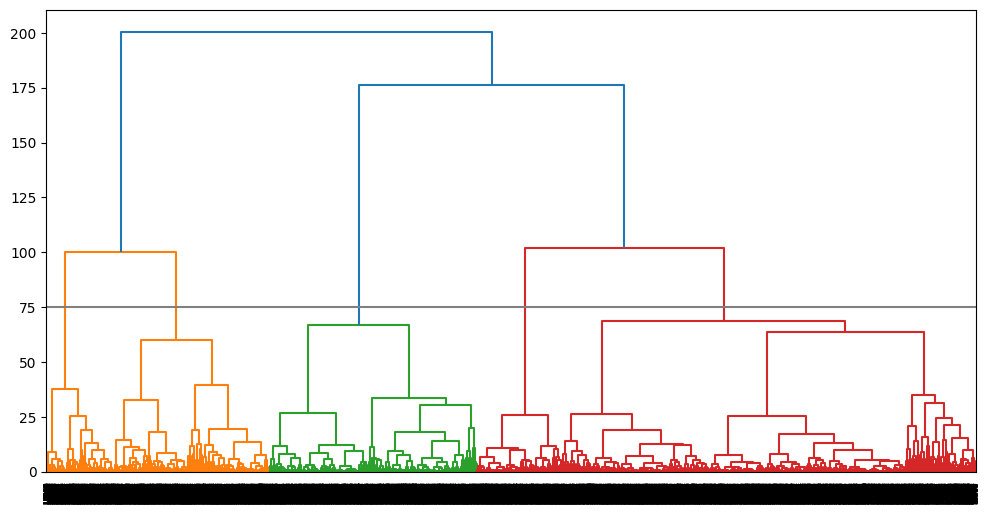

In [178]:
# Creating dendogram visualisation of merged dataframe
plt.figure(figsize=(12, 6)) 
dend = shc.dendrogram(shc.linkage(merged_data_scaled_agglom[cols_to_scale], method="ward"))
plt.axhline(y=75, color="gray", linestyle="-")

In [160]:
# Performing agglomerative clusterig for best number of clusters
agglom = AgglomerativeClustering(n_clusters=5, metric="euclidean", linkage="ward")  
agglom.fit(merged_data_scaled_agglom[cols_to_scale])

AgglomerativeClustering(metric='euclidean', n_clusters=5)

In [161]:
# Calculating silhoutte score for agglomerative clusterig for best number of clusters
silhouette_score(merged_data_scaled_agglom[cols_to_scale], agglom.labels_)

0.41065986593083037

### DBSCAN

In [162]:
merged_data_scaled_dbscan = merged_data_scaled.copy()

In [ ]:
# Calculating silhoutte scores for each possible epsilon and min_sample under DBSCAN cluseting algorithm
epsilons = np.arange(0.3, 0.61, 0.01)
min_samples = range(10, 31, 1)
scores_data_dbscan = pd.DataFrame(columns = ["epsilon", "min_sample", "silhouette_score"])

for i in epsilons:
    for k in min_samples:
        
        print(i, k)
       
        model = DBSCAN(eps=i, min_samples=k)
        model.fit(merged_data_scaled_dbscan[cols_to_scale])
        scores_data_dbscan.loc[len(scores_data_dbscan)] = {"epsilon": i, "min_sample": k, "silhouette_score": silhouette_score(merged_data_scaled_dbscan[cols_to_scale], model.labels_)}

In [ ]:
scores_data_dbscan.sort_values(by="silhouette_score", ascending=False).head(10)

In [163]:
# Defining distance for k-distances visualisation
neighbor = NearestNeighbors(n_neighbors=14)
neighbors = neighbor.fit(merged_data_scaled_dbscan[cols_to_scale])
distances, indices = neighbors.kneighbors(merged_data_scaled_dbscan[cols_to_scale])

In [164]:
# Defining distance for k-distances visualisation
df_distances = pd.DataFrame(distances).rename(columns={13: "epsilon"})
df_distances = df_distances.drop(df_distances.loc[:, 0:12].columns, axis=1)
df_distances = df_distances.sort_values(by=["epsilon"], ascending=True).reset_index(drop=True).reset_index().rename(columns={"index": "points"})

In [165]:
# Creating k-distances visualisation of merged dataframe
k_distances_viz_dbscan = alt.Chart(df_distances).mark_line().encode(
    x=alt.X("points:Q", axis=alt.Axis(gridColor="lightgray", tickMinStep=2000, title=None)),
    y=alt.Y("epsilon:Q", axis=alt.Axis(gridColor="lightgray", tickMinStep=0.2, title="Epsilon")),
    tooltip=[alt.Tooltip("epsilon:Q", title="Epsilon")]
)

In [166]:
# Creating line for of k-distances visualisation of merged dataframe
line_viz_dbscan = alt.Chart(pd.DataFrame({"epsilon": [0.5]})).mark_rule(color="darkorange", strokeWidth=2).encode(y=alt.Y("epsilon:Q"))

In [179]:
(k_distances_viz_dbscan + line_viz_dbscan).properties(width=900, height=600, title=alt.TitleParams(text=["K-distance graph for DBSCAN algorithm for paying users"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.LayerChart(...)

In [168]:
# Performing DBSCAN clustering for best number of epsilon and min_sample
dbscan = DBSCAN(eps=0.5, min_samples=14)
dbscan.fit(merged_data_scaled_dbscan[cols_to_scale])

DBSCAN(min_samples=14)

In [169]:
# Calculating silhoutte score for DBSCAN clustering for best number of epsilon and min_sample
silhouette_score(merged_data_scaled_dbscan[cols_to_scale], dbscan.labels_)

0.4614755748999285

In [170]:
# Performing TSNE
merged_data_scaled_dbscan_TSNE = TSNE(n_components=2).fit_transform(merged_data_scaled_dbscan[cols_to_scale])
df_merged_data_scaled_dbscan_TSNE = pd.DataFrame(merged_data_scaled_dbscan_TSNE)
df_merged_data_scaled_dbscan_TSNE["cluster"] = dbscan.labels_
df_merged_data_scaled_dbscan_TSNE.columns = ["x1", "x2", "cluster"]

In [171]:
# Creating scatterplot visualisation of TSNE with DBSCAN resulting clusters
tsne_viz_dbscan = alt.Chart(df_merged_data_scaled_dbscan_TSNE).mark_circle().encode(
    x=alt.X("x1:Q", axis=alt.Axis(gridColor="lightgray", tickMinStep=20, title=None)),
    y=alt.Y("x2:Q", axis=alt.Axis(gridColor="lightgray", tickMinStep=20, title=None)),
    color=alt.Color("cluster:N", legend=alt.Legend(title="Cluster")),
    tooltip=[alt.Tooltip("cluster:N", title="Cluster")]
)

In [172]:
tsne_viz_dbscan.properties(width=900, height=600, title=alt.TitleParams(text=["TSNE for DBSCAN algorithm for paying users"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.Chart(...)

In [173]:
# Merging data frame with scaled DBSCAN clustering results with original non-scaled merged data frame
merged_data_scaled_dbscan = merged_data_scaled_dbscan.merge(merged_data, how="left", on="appsflyer_id", left_index=False, right_index=False)
merged_data_scaled_dbscan = merged_data_scaled_dbscan.rename(columns={"platform_x": "platform_scaled", "gender_x": "gender_scaled", "age_x": "age_scaled", "revenue_x": "revenue_scaled", "num_chat_astro_screen_open_x": "num_chat_astro_screen_open_scaled", "num_comp_screen_open_x": "num_comp_screen_open_scaled", "num_zodiac_screen_open_x": "num_zodiac_screen_open_scaled",
                                                                      "platform_y": "platform", "gender_y": "gender", "age_y": "age", "revenue_y": "revenue", "num_chat_astro_screen_open_y": "num_chat_astro_screen_open", "num_comp_screen_open_y": "num_comp_screen_open", "num_zodiac_screen_open_y": "num_zodiac_screen_open",
                                                                     })

In [174]:
merged_data_scaled_dbscan["cluster"] = dbscan.labels_

In [175]:
# Creating grouped by attributes pivot table of means of DBSCAN resulting clusters
cluster_means_dbscan = pd.DataFrame(merged_data_scaled_dbscan[["platform", "gender", "age", "revenue", "num_chat_astro_screen_open", "num_comp_screen_open", "num_zodiac_screen_open", "cluster"]].groupby("cluster").mean().to_records())
cluster_means_dbscan = cluster_means_dbscan.melt(id_vars=["cluster"], var_name="attribute", value_name="mean")

In [176]:
# Creating grouped by attributes bar chart visualisation of means of DBSCAN resulting clusters
grouped_bar_chart_clusters_attrib_dbscan = alt.Chart(cluster_means_dbscan).mark_bar().encode(
    x=alt.X("cluster:N", axis=alt.Axis(title="Cluster", labelAngle=0)),
    y=alt.Y("mean:Q", axis=alt.Axis(title="Cluster means")),
    color=alt.Color("attribute:N", legend=alt.Legend(title="Feature")),
    column=alt.Column("attribute:N", title="Attribute", header=alt.Header(labels=False, title=None)),
    tooltip=[alt.Tooltip("attribute:N", title="Attribute"), alt.Tooltip("cluster:Q", title="Cluster"), alt.Tooltip("mean:Q", format=",.2f", title="Cluster center")]
)

In [177]:
grouped_bar_chart_clusters_attrib_dbscan.properties(width=100, height=500, title=alt.TitleParams(text=["Cluster means for DBSCAN algorithm for paying users"], fontSize=14, anchor="middle", baseline="bottom")).configure_view(strokeWidth=0)

alt.Chart(...)